# RNN

In [5]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

## テストデータ生成

ノイズありの波を生成

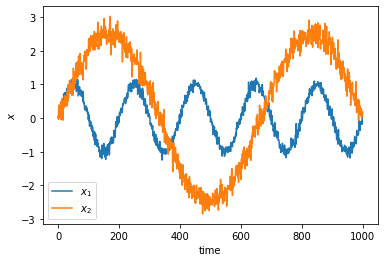

In [33]:
N = 1000
A, B = 1.0, 2.5   # 振幅
An, Bn = 0.1, 0.2  # ノイズの振幅

x = np.concatenate([
    A*np.sin(np.linspace(0, 10*np.pi, N)) + An*np.random.randn(N),
    B*np.sin(np.linspace(0, 3*np.pi, N)) + Bn*np.random.randn(N),
]).reshape(2, N).T

plt.xlabel('time')
plt.ylabel('$x$')
plt.plot(range(x.shape[0]), x[:,0], label='$x_1$')
plt.plot(range(x.shape[0]), x[:,1], label='$x_2$')
plt.legend()

plt.show()

## RNN の理論

全てのベクトルは行ベクトルであるとする。

$$
\boldsymbol{m_t}
\equiv
\boldsymbol{h}_{t-1} W_{\boldsymbol{h}} +
\boldsymbol{x}_t W_{\boldsymbol{x}} +
\boldsymbol{b}
$$

と置けば、

$$
\boldsymbol{h}_t
=
\tanh{\boldsymbol{m_t}}
$$

$$
m_{t,i}
=
\sum_k h_{t-1,k} W_{\boldsymbol{h}, ki} +
\sum_l x_{t,l} W_{\boldsymbol{x}, li} + b_i
$$

$$
h_{t,i}
=
\displaystyle
\tanh m_{t,i}
$$

後で使うので $$m_{t,i}$$ の微分を計算しておく：

$$
\begin{cases}
\cfrac{\partial m_{t,i}}{\partial h_{t-1,j}} &= W_{\boldsymbol{h},ji}
\\
\cfrac{\partial m_{t,i}}{\partial x_{t,j}} &= W_{\boldsymbol{x},ji}
\\
\cfrac{\partial m_{t,i}}{\partial W_{\boldsymbol{h},jk}} &= h_{t-1,j} \delta_{ik}
\\
\cfrac{\partial m_{t,i}}{\partial W_{\boldsymbol{x},jk}} &= x_{t,j} \delta_{ik}
\\
\cfrac{\partial m_{t,i}}{\partial b_{j}} &= \delta_{ij}
\end{cases}
$$

誤差逆伝播を考える。

$$
\begin{eqnarray}
\cfrac{\partial J}{\partial h_{t-1,i}}
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial h_{t-1,i}}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial}{\partial h_{t-1,i}} \tanh m_{t,j}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial h_{t-1,i}}
\\
&=&
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
W_{\boldsymbol{h}, ij}
\\
&=&
\left\{
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
W_{\boldsymbol{h}}^{\rm T}
\right\}_{i}
\end{eqnarray}
$$

同様に、

$$
\cfrac{\partial J}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial x_{t,i}}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
W_{\boldsymbol{x}, ij}
=
\left\{
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
W_{\boldsymbol{x}}^{\rm T}
\right\}_{i}
$$

$$
\cfrac{\partial J}{\partial W_{\boldsymbol{h},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\cfrac{\partial h_{t,k}}{\partial W_{\boldsymbol{h},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\left( 1 - \tanh^2 m_{t,k} \right)
\cfrac{\partial m_{t,k}}{\partial W_{\boldsymbol{h},ij}}
=
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
h_{t-1,i}
=
\left\{
\boldsymbol{h}_{t-1}^{\rm T}
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
\right\}_{ij}
$$

$$
\cfrac{\partial J}{\partial W_{\boldsymbol{x},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\cfrac{\partial h_{t,k}}{\partial W_{\boldsymbol{x},ij}}
=
\displaystyle \sum_k
\cfrac{\partial J}{\partial h_{t,k}}
\left( 1 - \tanh^2 m_{t,k} \right)
\cfrac{\partial m_{t,k}}{\partial W_{\boldsymbol{x},ij}}
=
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
x_{t,i}
=
\left\{
\boldsymbol{x}_t^{\rm T}
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)
\right\}_{ij}
$$

$$
\cfrac{\partial J}{\partial b_i}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\cfrac{\partial h_{t,j}}{\partial b_i}
=
\displaystyle \sum_j
\cfrac{\partial J}{\partial h_{t,j}}
\left( 1 - \tanh^2 m_{t,j} \right)
\cfrac{\partial m_{t,j}}{\partial b_i}
=
\cfrac{\partial J}{\partial h_{t,i}}
\left( 1 - \tanh^2 m_{t,i} \right)
=
\left(
    \cfrac{\partial J}{\partial \boldsymbol{h}_t}
    \odot
    \left( 1 - \tanh^2 \boldsymbol{m}_t \right)
\right)_{i}
$$

In [1]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        """
        Wh : hの重み
        Wx : xの重み
        b  : バイアス
        """
        self.Wh = Wh  # 全てのRNNブロックで同一の重みを共有
        self.Wx = Wx  # 全てのRNNブロックで同一の重みを共有
        self.b = b    # 全てのRNNブロックで同一の重みを共有
        self.grads = [
            np.zeros_like(Wx),
            np.zeros_like(Wh),
            np.zeros_like(b)
        ]             # 各RNNブロックが個別に保有
        self.cache = None
    
    def forward(self, X, Hprev, is_training=False):
        """
        X : その時刻の入力（行ベクトルを積んだ行列）
        H : 1つ前の時刻の出力（行ベクトルを積んだ行列）
        """
        H = np.tanh(np.dot(X, self.Wx) + np.dot(Hprev, self.Wh) + self.b)
        if is_training:
            self.cache = (X, H, Hprev)
        return H
    
    def backward(self, dH):
        X, H, Hprev = self.cache
        self.cache = 0
        tmp = dH * (1.0 - H * H)
        
        dX = np.dot(tmp, self.Wx.T)
        dHprev = np.dot(tmp, self.Wh.T)
        dWx = np.dot(X.T, tmp)
        dWh = np.dot(Hprev.T, tmp)
        db = tmp.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dX, dHprev


class TimeRNN:
    """
    Trancated BPTT を行う際の1セットを表すレイヤ
    """
    def __init__(self, Wx, Wh, b, stateful=False):
        """
        stateful : 次の TimeRNN レイヤへ隠れ状態Hを引き継ぐかどうか
        """
        self.params = [Wx, Wh, b]
        self.grads = [
            np.zeros_like(Wx),
            np.zeros_like(Wh),
            np.zeros_like(b)
        ]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def forward(self, xs, is_training=False):
        """
        Xs : データサンプル
            - D次元のデータサンプルを
            - 時系列にT個並べたものを
            - N個のバッチにまとめた3次元配列
        """
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        for t in range(T):
            layer = RNN(Wx, Wh, b)
            self.h = layer.forward(xs[:, t, :], self.h, is_training)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        
        return hs
            
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs
    
    def reset_state(self):
        """
        隠れ状態をリセット
        学習済みモデルで予測を行うときに使う
        """
        self.h = None


class Affine:
    def __init__(self, W, b):
        # モデルの重み
        self.params = [W, b]
        # 重みの勾配
        self.grads = [np.empty_like(W), np.empty_like(b)]
        # 誤差逆伝播用の中間データ
        self.cache = None

    def forward(self, X, is_training=False):
        W, b = self.params
        out = np.dot(X, W) + b
        
        if is_training:
            self.cache = X
        return out

    def backward(self, dout):
        W, b = self.params
        X = self.cache
        self.cache = None

        dX = np.dot(dout, W.T)
        dW = np.dot(X.T, dout)
        db = dout.sum(axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dX


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.empty_like(W), np.empty_like(b)]
        self.cache = None
    
    def forward(self, xs, is_training=False):
        W, b = self.params
        N, T, D = xs.shape
        D, H = W.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        for t in range(T):
            layer = Affine(W, b)
            h = layer.forward(xs[:, t, :], is_training)
            hs[:, t, :] = h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        W, b = self.params
        N, T, H = dhs.shape
        D, H = W.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        grads = [0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward(dhs[:, t, :])
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        return dxs


class LeastSquareLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, X_pred, X_corr, is_training=False):
        X_err = X_pred - X_corr
        cost = (X_err*X_err).sum()
        if is_training:
            self.cache = X_err
        return cost
    
    def backward(self, dout=1.0):
        X_err = self.cache
        batch_size = X_err.shape[0]
        self.cache = None
        return 2 * X_err * dout / batch_size


class TimeLeastSquareLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, xs, xs_corr, is_training=False):
        N, T, D = xs.shape
        
        cost = 0
        self.layers = []
        for t in range(T):
            layer = LeastSquareLoss()
            cost += layer.forward(xs[:, t, :], xs_corr[:, t, :], is_training)
            self.layers.append(layer)
        
        if is_training:
            self.cache = (N, T, D)
        
        return cost
    
    def backward(self):
        N, T, D = self.cache
        dxs = np.empty((N, T, D), dtype='f')
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward()
            dxs[:, t, :] = dx
        
        return dxs


class SoftmaxWithLoss:
    def __init__(self):
        self.cache = None
        
    def forward(self, X, P_corr, is_training=False):
        P_pred = self.__softmax(X)
        cost = self.__calc_cost(P_pred, P_corr)
        if is_training:
            self.cache = (P_pred, P_corr)
        return cost
    
    def backward(self, dout=1.0):
        P_pred, P_corr = self.cache
        self.cache = None
        batch_size = P_corr.shape[0]
        dX = (P_pred - P_corr) * dout / batch_size
        return dX
    
    def __softmax(self, X):
        """
        X : 行ベクトルのデータサンプルを積み重ねた行列
        """
        expX = np.exp(X)
        return (expX.T / expX.sum(axis=1)).T
    
    def __calc_cost(self, P_pred, P_corr):
        """
        P_pred : 予測所属確率の行ベクトルを積み重ねた行列
        P_corr : 正解所属確率
        """
        cost = - np.sum(P_corr * np.log(P_pred) + (1.0 - P_corr) * np.log(1.0 - P_pred), axis=0)
        cost = np.average(cost)
        return cost


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.cache = None
    
    def forward(self, xs, P_corr, is_training=False):
        N, T, D = xs.shape
        
        cost = 0
        self.layers = []
        for t in range(T):
            layer = SoftmaxWithLoss(is_training)
            cost += layer.forward(xs[:, t, :], P_corr[:, t, :])
            self.layers.append(layer)
        
        if is_training:
            self.cache = (N, T, D)
        
        return cost
    
    def backward(self):
        N, T, D = self.cache
        dxs = np.empty((N, T, D), dtype='f')
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx = layer.backward()
            dxs[:, t, :] = dx
        
        return dxs
    

class TimeRNNRegression:
    """
    回帰問題を解く
    """
    def __init__(self, D, H):
        """
        D : データの次元
        H : RNN 隠れ状態のノード数
        """
        self.D = D
        self.H = H
        
        # レイヤ初期化
        sigma = 0.01
        self.Wx_rnn = sigma * np.random.randn(D, H)
        self.Wh_rnn = sigma * np.random.randn(H, H)
        self.b_rnn = sigma * np.random.randn(H)
        self.W_aff = sigma * np.random.randn(H, D)
        self.b_aff = sigma * np.random.randn(D)
        self.layers = [
            TimeRNN(self.Wx_rnn, self.Wh_rnn, self.b_rnn, stateful=True),
            TimeAffine(self.W_aff, self.b_aff)
        ]
        self.loss_layer = TimeLeastSquareLoss()
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ys, is_training=False):
        """
        xs : 入力。T個の時系列データ（標準化済）
        ys : 主力の正解。T個の時系列データ（標準化済）
        """
        out = xs
        for layer in self.layers:
            out = layer.forward(out, is_training)
        loss = self.loss_layer.forward(out, ys, is_training)
        return loss
    
    def backward(self):
        din = self.loss_layer.backward()
        for layer in reversed(self.layers):
            din = layer.backward(din)
        return din
    
    def reset_state(self):
        self.layers[0].reset_state()


class RNNRegressionModel:
    """
    回帰問題を解く
    """
    def __init__(self, eta, batch_size, D, T, H):
        """
        eta        : 学習率
        batch_size : ミニバッチ学習のバッチサイズ
        D          : データの次元
        T          : Trancated BPTT を行う際の RNN ブロック数
        H          : RNN 隠れ状態のノード数
        """
        self.eta = eta
        self.batch_size = batch_size
        self.D = D
        self.T = T
        self.H = H
        
        self.x_ave = None  # 平均値
        self.x_sd = None   # 標準偏差
        self.layer = TimeRNNRegression(D, H)
        
        self.loss = []
    
    def train(self, x, epochs):
        """
        x      : 次元D,長さLの時系列データ
        epochs :
        """
        # 学習の入力時系列長
        L_in = x.shape[0] - 1
        
        # 標準化
        self.x_ave = x.mean(axis=0)
        self.x_sd = x.std(axis=0)
        x_std = (x - self.x_ave) / self.x_sd
        
        # 入力データと正解データ
        x_2cycle = np.concatenate([x_std, x_std])  # 末尾に到達したら先頭に戻る
        x_prev = x_2cycle[:-1]
        x_next = x_2cycle[1:]
        
        jump = L_in // self.batch_size
        for e in range(epochs):
            # バッチデータ生成
            offset = np.random.randint(jump)
            batch_x_prev = np.empty((self.batch_size, L_in, self.D), dtype='f')
            batch_x_next = np.empty((self.batch_size, L_in, self.D), dtype='f')
            for i in range(self.batch_size):
                batch_x_prev[i] = x_prev[offset:offset+L_in]
                batch_x_next[i] = x_next[offset:offset+L_in]
                offset += jump
            # 学習
            base = 0
            while base < L_in:
                t_start = base
                t_end = t_start + self.T
                if t_end >= L_in:
                    t_end = L_in
                base += self.T
                
                # forward propagation
                xs = batch_x_prev[:, t_start:t_end, :]
                ys = batch_x_next[:, t_start:t_end, :]
                loss = self.layer.forward(xs, ys, is_training=True)
            
                # back propagation
                self.layer.backward()
                
                # update params
                for i in range(len(self.layer.params)):
                    self.layer.params[i] -= self.eta * self.layer.grads[i]
            
            self.loss.append(loss)
        
    def predict(self, x):
        """
        x : D次元のデータが時系列にL個並んだもの
        """
        # RNN の隠れ状態をリセット
        self.layer.reset_state()
        
        L, D = x.shape
        x_std = (x - self.x_ave) / self.x_sd
        x_std = x_std.reshape(1, L, D)
        
        out = x_std
        for l in self.layer.layers:
            out = l.forward(out)
        out = out.reshape(L, D)
        result = out * self.x_sd + self.x_ave
        return result[-1]

5.0323101580142975


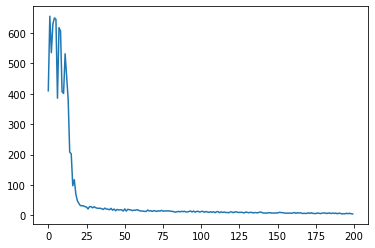

In [5]:
# 学習
N = 1000
T = 20
A, B, C = 10.0, 2.5, 5.0    # 振幅
An, Bn, Cn = 0.1, 0.2, 0.1  # ノイズの振幅
An, Bn, Cn = 0, 0, 0
x = np.concatenate([
    A*np.sin(np.linspace(0, 40*np.pi, N)) + An*np.random.randn(N),
    B*np.sin(np.linspace(0, 20*np.pi, N)) + Bn*np.random.randn(N),
    C*np.sin(np.linspace(0, 80*np.pi, N)) + Cn*np.random.randn(N)
]).reshape(3, N).T


#model = RNNRegression(eta=1.0e-4, batch_size=10, T=T, H=50)
model = RNNRegressionModel(eta=1.0e-4, batch_size=10, D=x.shape[1], T=T, H=20)
model.train(x, 200)
print(model.loss[-1])


# 学習曲線
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(model.loss)), model.loss)
plt.show()

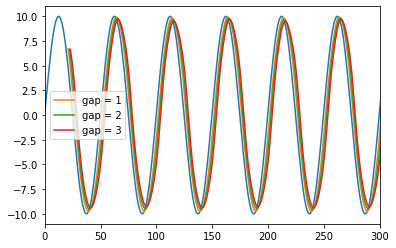

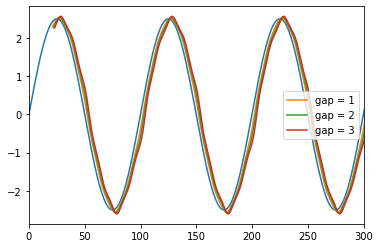

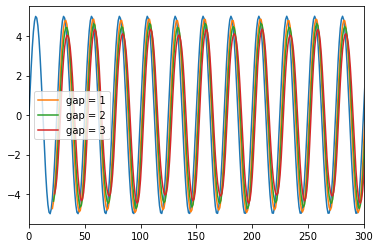

In [6]:
max_gap = 3
i_base = T
#x_pred = np.empty((max_gap, len(x)-T-max_gap, x.shape[-1]))
x_pred_list = []
for i_base in range(len(x)-max_gap-T):
    x_in = x[i_base:i_base+T].copy()
    x_pred = []
    for _ in range(max_gap):
        x_pred.append(model.predict(x_in))
        x_in[:-1] = x_in[1:]
        x_in[-1] = x_pred[-1]
    x_pred_list.append(x_pred)
x_pred_list = np.array(x_pred_list)


for d in range(x.shape[-1]):
    plt.xlim([0,300])
    plt.plot(range(len(x)), x[:,d])
    for g in range(max_gap):
        data = x_pred_list[:, g, d]
        plt.plot(range(T+g+1, len(data)+T+g+1), data, label='gap = {}'.format(g+1))
    plt.legend()
    plt.show()

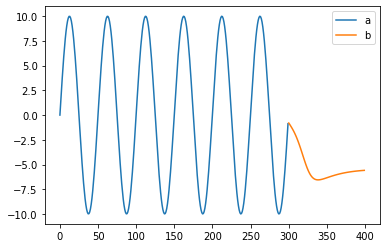

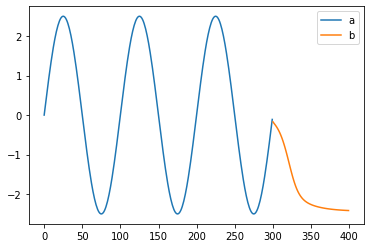

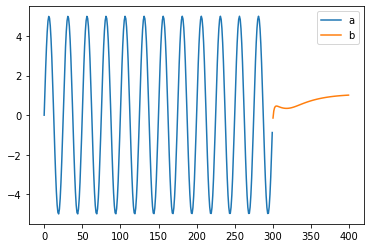

In [9]:
start = 0
T_corr = 300
T_pred = 100

x_in = x[start:start+T_corr].copy()
x_pred = []
for _ in range(T_pred):
    x_next = model.predict(x_in)
    x_pred.append(x_next)
    x_in[:-1] = x_in[1:]
    x_in[-1] = x_next
x_pred = np.array(x_pred)

for d in range(x.shape[1]):
    plt.plot(range(T_corr), x[start:start+T_corr,d], label='a')
    plt.plot(range(T_corr, T_corr+x_pred.shape[0]), x_pred[:,d], label='b')
    plt.legend()
    plt.show()

#plt.plot(range(T_corr), x[start:start+T_corr,1], label='a')
#plt.plot(range(T_corr, T_corr+x_pred.shape[0]), x_pred[:,1], label='b')
#plt.legend()
#plt.show()